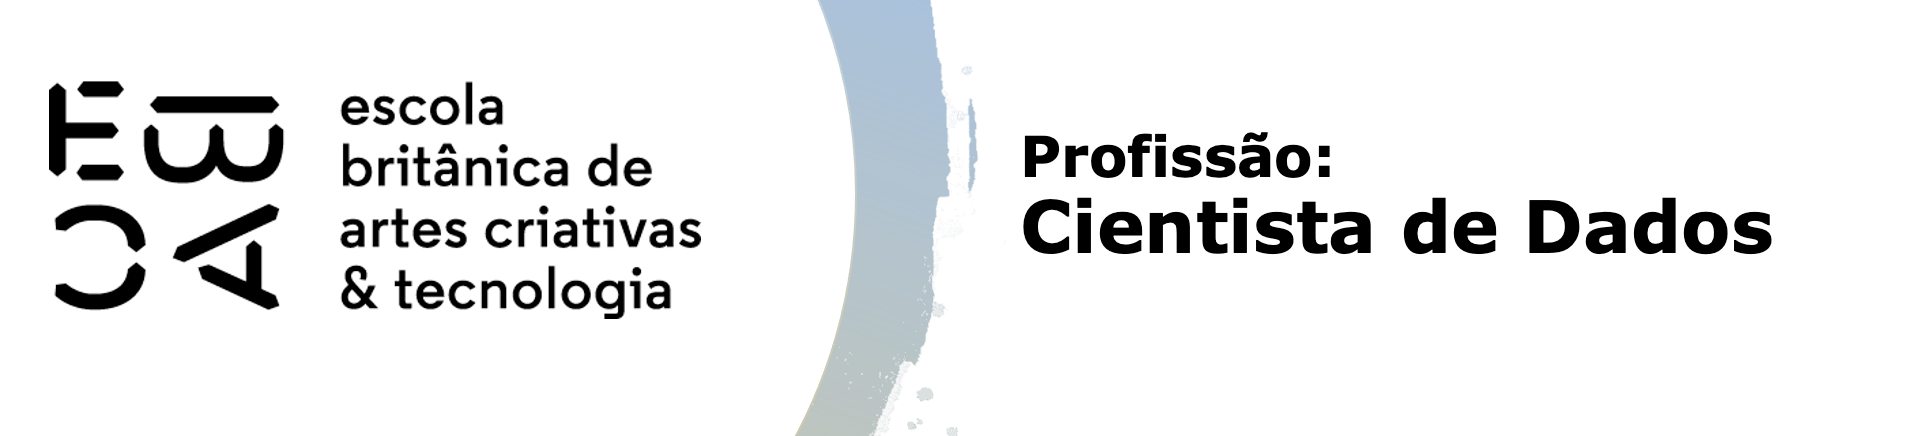

# Análise descritiva IV

Neste módulo vamos focar em análises descritivas e exploratórias específicas para modelos de classificação binária, utilizadas tradicionalmente em modelos de *Credit Scoring*. Essas técnicas são bastante gerais e vão funcionar igualmente bem para outras realidades com pouca necessidade de adaptação, e estão bastante maduras dentro do universo de finanças.

Num problema de concessão de crédito, temos fenômenos econômicos como desemprego, inflação etc, além de outros efeitos que afetam a todos com igual intensidade ao mesmo tempo, como ações de concorrência, alterações na legislação e uma infinidade de outros efeitos que podem ser mais ou menos relevantes, e muitas vezes difíceis de se medir e registrar. Esses efeitos que afetam a todos os clientes são chamados de efeitos sistêmicos, e podem gerar alterações no modelo ao longo do tempo. Vamos ver algumas análises que nos ajudam a entender esse tipo de efeito. 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ttnc = sns.load_dataset('titanic')
ttnc.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Cálculo do *WOE*

**Lembrete**:

O WOE (*weight of evidence*) é uma medida de relevância das categorias de uma variável para classificação binária, alinhada com a regressão logística. O *WOE* é uma medida comparativa que indica o quanto um perfil é diferente da população geral em termos da probabilidade do evento que estamos estudando. Uma forma interessante de se entender o *WOE* é como o logaritmo da razão de chances de ocorrência do evento no perfil observado com relação à chance geral da população. Abaixo uma ótica matemática sobre como calcular este valor para a categoria *i* ($WOE_i$):

$$ WOE_i=log(RC_i) $$

em que $RC_i$ é a razão de chances do perfil $i$ com relação ao público geral. Ou seja:

$$ WOE_i=log(RC_i)=log(\frac{Odds_i}{Odds_{geral}}) $$
ou ainda:
$$ WOE=log(Odds_i) - log(Odds_{geral}) $$

Lembrando que $Odds_i$ é o número de eventos do perfil i dividido pelo número de não eventos no mesmo perfil. Que também pode ser calculado como $P_i/(1-P_i)$.

In [2]:
tab = pd.crosstab(ttnc.sex, ttnc.survived, margins=True, margins_name='total')
tab

survived,0,1,total
sex,,,
female,81,233,314
male,468,109,577
total,549,342,891


In [3]:
tab['bad_rate'] = tab[1]/tab['total']
tab

survived,0,1,total,bad_rate
sex,,,,
female,81,233,314,0.742038
male,468,109,577,0.188908
total,549,342,891,0.383838


In [7]:
tab['odds'] = tab[1]/tab[0]
tab['odds_ratio'] = tab['odds']/tab.loc['total', 'odds']
tab['woe'] = np.log(tab.odds_ratio)
tab

survived,0,1,total,bad_rate,odds,odds_ratio,woe
sex,,,,,,,
female,81,233,314,0.742038,2.876543,4.617609,1.529877
male,468,109,577,0.188908,0.232906,0.373875,-0.983833
total,549,342,891,0.383838,0.622951,1.000000,0.000000


In [5]:
2.876543/0.622951

4.617607163324242

In [8]:
tab['odds'] = tab[1]/tab[0]
tab['odds_ratio'] = tab['odds']/tab.loc['total', 'odds']

tab['logit'] = np.log(tab.odds)
tab['woe'] = np.log(tab.odds_ratio)
tab

survived,0,1,total,bad_rate,odds,odds_ratio,woe,logit
sex,,,,,,,,
female,81,233,314,0.742038,2.876543,4.617609,1.529877,1.056589
male,468,109,577,0.188908,0.232906,0.373875,-0.983833,-1.457120
total,549,342,891,0.383838,0.622951,1.000000,0.000000,-0.473288


In [9]:
tab.logit - tab.loc['total', 'logit']

sex
female    1.529877
male     -0.983833
total     0.000000
Name: logit, dtype: float64

### Forma prática de cálculo

Na forma acima, precisamos fazer muitas operações para chegar no WOE. Abaixo vamos descrever uma forma mais prática.

Essa razão $Odds_i/Odds_{geral}$ é a razão de chances (odds ratio) do perfil i sobre o perfil geral. Considere a seguinte tabela cruzada:

|Perfil|Eventos|Não eventos|Total|
|:|:|:|:|
|1|$a_{11}$|$a_{12}$|$a_{1.}$|
|2|$a_{21}$|$a_{22}$|$a_{2.}$|
|Total|$a_{.1}$|$a_{.2}$|$a_{..}$|

Uma forma prática de calcular esse *odds ratio* é a seguinte:

- Calculamos as proporções para as categorias da variável (dado evento, e dado não evento): 
$$\%eventos_i = \frac{a_{i1}}{a_{.1}}$$
$$\%não\ eventos_i = \frac{a_{i2}}{a_{.2}}$$
<br>
- O odds ratio da categoria i com relação ao perfil geral será: 
$$OR = \frac{\%eventos_i}{\%não\ eventos_i}$$

de onde obtemos:

$$WOE_i = log\left(\frac{\%eventos_i}{\%não\ eventos_i}\right) $$

In [15]:
tab = pd.crosstab(ttnc.sex, ttnc.survived, margins=True, margins_name='total')
tab

survived,0,1,total
sex,,,
female,81,233,314
male,468,109,577
total,549,342,891


In [17]:
tab['pct_nao_evento'] = tab[0]/tab.loc['total',0]
tab['pct_evento']     = tab[1]/tab.loc['total',1]
tab

survived,0,1,total,pct_nao_evento,pct_evento
sex,,,,,
female,81,233,314,0.147541,0.681287
male,468,109,577,0.852459,0.318713
total,549,342,891,1.000000,1.000000


In [18]:
tab['RC'] = tab['pct_evento']/tab['pct_nao_evento']
tab['WOE'] = np.log(tab['pct_evento']/tab['pct_nao_evento'])
tab

survived,0,1,total,pct_nao_evento,pct_evento,RC,WOE
sex,,,,,,,
female,81,233,314,0.147541,0.681287,4.617609,1.529877
male,468,109,577,0.852459,0.318713,0.373875,-0.983833
total,549,342,891,1.000000,1.000000,1.000000,0.000000


In [21]:
np.exp(1.529877)

4.617608821483404

## *Information Value* (IV)

O *Information Value* é uma medida de poder preditivo muito popular na área de crédito. É um indicador que mede o quanto uma variável é capaz de 'separar' individualmente eventos e não eventos, com base no WOE, que está indimamente associado com a função linear da regressão logística.

O *IV* pode ser calculado assim:

$$ \sum_{i=1}^{num-classes} \left(\%eventos_i - \%não\ eventos_i\right)WOE_i $$

Naeem Siddiqi recomenda as seguintes regras de bolso para interpretar o IV:

|Faixa|Poder preditivo|
|:-|:-|
|0 a 0,02| Inútil |
|0,02 a 0,1| Fraco |
|0,1 a 0,3| Médio |
|0,3 a 0,5| Forte |
|0,5 ou mais| Suspeito de tão alto |

Lembro que Siddiqi recomenda estas regras de bolso da experiência dele, que é muito vasta em modelos de crédito. Outras áreas de concentração podem tender a apresentar relações mais sutís ou mais evidentes.

O IV parte de uma tabela cruzada. Vamos fazer um exemplo com a base do Titanic:

In [22]:
tab = pd.crosstab(ttnc.sex, ttnc.survived, margins=True, margins_name='total')
tab

survived,0,1,total
sex,,,
female,81,233,314
male,468,109,577
total,549,342,891


Agora vamos calcular o percentual de eventos e o percentual de não eventos. Feito isto, já vimos que fica bastante fácil calcular o WOE.

In [25]:
rótulo_nao_evento = tab.columns[1]
rótulo_nao_evento

1

In [26]:
tab = pd.crosstab(ttnc.sex, ttnc.survived, margins=True, margins_name='total')

rótulo_evento = tab.columns[0]
rótulo_nao_evento = tab.columns[1]

tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab

survived,0,1,total,pct_evento,pct_nao_evento,woe
sex,,,,,,
female,81,233,314,0.147541,0.681287,-1.529877
male,468,109,577,0.852459,0.318713,0.983833
total,549,342,891,1.000000,1.000000,0.000000


Com as quantidades calculadas na célula acima, fica bem fácil calcular o *Information Value*.

Vamos fazer o cálculo das parcelas no *data frame*, mas como veremos na célula seguinte, podemos calcular em uma única linha:

In [27]:
tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
print(tab.iv_parcial.sum())
tab

1.3416814135556492


survived,0,1,total,pct_evento,pct_nao_evento,woe,iv_parcial
sex,,,,,,,
female,81,233,314,0.147541,0.681287,-1.529877,0.816565
male,468,109,577,0.852459,0.318713,0.983833,0.525116
total,549,342,891,1.000000,1.000000,0.000000,0.000000


In [28]:
((tab.pct_evento - tab.pct_nao_evento)*tab.woe).sum()

1.3416814135556492

### Calculando o IV para um conjunto grande de variáveis

Agora vamos definir uma estratégia para calcular o IV para um conjunto grande de variáveis. Essa estratégia vai ser assim:

1. Vamos construir um metadados (*metadata*), que é uma tabela que vai conter informações sobre as variáveis: tipo de dado, número de categorias etc, inclusive o *Information Value*.
2. Vamos atribuir papéis a essas variáveis, como "resposta" - a variável que vamos prever, "covariável" as variáveis que vão ajudar a prever a resposta
3. Vamos definir uma função que calcula o IV
4. Vamos calcular o IV para cada variável tipo "covariavel" e popular o metadados.

**1. Definindo o metadados**

In [33]:
ttnc.drop(columns=['class', 'deck', 'embark_town', 'alive'], inplace=True)
metadados = pd.DataFrame({'dtype':ttnc.dtypes})
metadados

,dtype
survived,int64
pclass,int64
sex,object
age,float64
sibsp,int64
parch,int64
fare,float64
embarked,object
who,object
adult_male,bool


**2. Atribuindo papéis**

A atribuição de papéis pode ser útil para localizarmos determinadas variáveis em um banco de dados especialmente grande. Em projetos maiores, é muito útil manter uma lista das variáveis da tabela em excel mesmo, com algumas anotações sobre elas. Tipicamente, a primeira lista de variáveis vem da aplicação que usamos, no caso o Python, e já vem com algumas informações que calculamos.

Vamos usar esse metadados para identificar as variáveis explicativas, ou "covariáveis" como estamos chamando aqui (ou ainda *features*, como se diz na literatura *machinelearnica*).

In [34]:
metadados['papel'] = 'covariavel'
metadados.loc['survived','papel'] = 'resposta'
metadados['nunique'] = ttnc.nunique()
metadados

,dtype,papel,nunique
survived,int64,resposta,2
pclass,int64,covariavel,3
sex,object,covariavel,2
age,float64,covariavel,88
sibsp,int64,covariavel,7
parch,int64,covariavel,7
fare,float64,covariavel,248
embarked,object,covariavel,3
who,object,covariavel,3
adult_male,bool,covariavel,2


**3. Definindo a função**

Vamos fazer uma função que recebe como entrada o nome de uma *feature* (ou variável explicativa), o nome da variável resposta (ou *target*), e retorna o IV.

In [35]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv = IV(ttnc.sex, ttnc.survived)
iv

1.3416814135556492

**4. Populando o metadados**

Agora vamos criar uma coluna nova no metadados e popular com o IV da respectiva variável.

Um dos maiores desafios de se automatizar uma tarefa como essa de calcular o IV para muitas variáveis é tratar as exceções. Quando há categorias com pouca frequencia, o cálculo do IV pode resultar em uma divisão por zero. Isso costuma ocorrer com uma certa frequencia quando a variável é contínua.

Vamos fazer um tratamento básico, até um tanto grosseiro, de categorizar a covariável em 5 grupos caso ela tenha muitas categorias.

Mas pode ser importante fazer um pré-processamento ou uma lógica mais sofisticada dependendo do problema que se estiver encontrando.

In [36]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>5):
        metadados.loc[var, 'IV'] = IV(pd.qcut(ttnc[var],5,duplicates='drop'), ttnc.survived)
    else: 
        metadados.loc[var, 'IV'] = IV(ttnc[var], ttnc.survived)
    
metadados

,dtype,papel,nunique,IV
survived,int64,resposta,2,NaN
pclass,int64,covariavel,3,0.500950
sex,object,covariavel,2,1.341681
age,float64,covariavel,88,0.050389
sibsp,int64,covariavel,7,0.022463
parch,int64,covariavel,7,0.013083
fare,float64,covariavel,248,0.504663
embarked,object,covariavel,3,0.122728
who,object,covariavel,3,1.486333
adult_male,bool,covariavel,2,1.436021


# Análise longitudinal

Uma parte importante da análise em modelos que se aplicam em grandes empresas - como os modelos de crédito - é a análise longitudinal.

É esperado que populações e mercados sofram mudanças o tempo todo. Algumas delas podem ser bruscas, como os chamados cisnes negros (ou *black swams*), outras podem ser sutís. É uma tarefa muito difícil fazer previsões acuradas de eventos como *black swams* antes que eles aconteçam (ex: quebra da bolsa, crise imobiliária, pandemia, etc). Mesmo eventos mais sutís também podem ser igualmente difíceis de se prever - economistas estão o tempo todo tentando prever inflação, câmbio, valores de ações, tudo com sucessos extremamente limitados, e altas doses de risco.

Por esse motivo, é muito comum (e até pragmático) deixar esse tipo de análise em uma etapa descritiva e indicadora dos riscos contidos no modelo. Se uma variável apresenta instabilidade, talvez seja melhor removê-la do modelo.

Esse tipo de processo, como o dos modelos de crédito, que necessita de previsões mensais, tem duas características importantes: o patamar (ou calibragem) e a discriminação. O patamar pode ser muito difícil de ser previsto, em especial quando o cenário é muito volátil ou quando o horizonte de previsão é muito longo. Mas a **razão de chances** entre dois indivíduos com classificações diferentes é mais fácil de se acertar.

## WOE no tempo

Uma análise clássica para se avaliar se uma variável é fator de risco *consistente* no tempo é a avaliação do WOE ao longo do tempo. A distância entre o WOE de duas categorias de uma variável é uma estimativa empírica do valor do parâmetro dessa variável na regressão logística. Assim, se os WOEs forem estáveis no tempo, a variável vai ser um preditor consistente e não vai trazer surpresas.

Podemos construir a mesma avaliação nas *taxas de evento observadas*, mas essas quantidades podem ser poluídas por mudanças sistêmicas na taxa de evento, o que não quer dizer que a *razão de chances* vai ser instável no tempo.

Vamos ver isso nos dados agregados que contém os visitantes de uma página web para recebimento de doações de uma instituição beneficente, indicando o sexo do visitante, e se virou doador ou não. Esses dados possuem uma certa *sazonalidade*, um período em que aumentam as taxas de conversão para doador em todos os perfis sistematicamente.

Vamos ver como a taxa de doadores e o WOE se comportam mês a mês

In [41]:
doadores = pd.read_pickle('doadores.pkl')
doadores.head()

freq
data_ref   sexo doador      
2019-01-01 m    sim      609
                nao     4391
           f    sim      219
                nao     4781
2019-02-01 m    sim      630

In [42]:
tab = doadores.unstack()['freq']
tab['N'] = tab.sum(axis=1)
tab['tx_evento'] = tab.sim/tab.N
tab.reset_index()
tab.head()

doador           sim   nao     N  tx_evento
data_ref   sexo                            
2019-01-01 f     219  4781  5000     0.0438
           m     609  4391  5000     0.1218
2019-02-01 f     254  4746  5000     0.0508
           m     630  4370  5000     0.1260
2019-03-01 f     280  4720  5000     0.0560

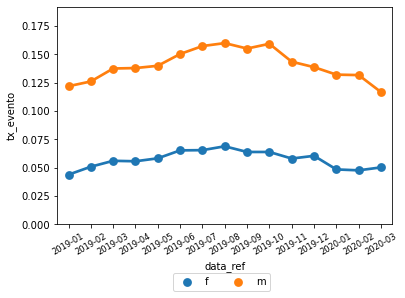

In [48]:
fig, ax = plt.subplots()

sns.pointplot(data=tab.reset_index(), x='data_ref', y='tx_evento', hue='sexo', ci=None, ax=ax)
ax.set_ylim([0, tab.tx_evento.max()*1.2]);

# Configurar rótulos do eixo X
labs = tab.index.get_level_values(level=0).unique()
labs2 = [x.to_period('M') for x in labs]

ax.set_xticklabels(labs2,rotation=30, fontsize='small')
ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

Podemos reparar que o período central do gráfico acima possui um aumento com relação aos demais, para ambos os perfis. É muito comum que o interesse central do modelo seja simplesmente identificar os perfis propensos a maiores taxas de eventos, o que pode ser avaliado de forma mais precisa utilizando o WOE.

In [49]:
tab.head()

doador           sim   nao     N  tx_evento
data_ref   sexo                            
2019-01-01 f     219  4781  5000     0.0438
           m     609  4391  5000     0.1218
2019-02-01 f     254  4746  5000     0.0508
           m     630  4370  5000     0.1260
2019-03-01 f     280  4720  5000     0.0560

In [53]:
rotulo_ev, rotulo_nev = ('sim', 'nao')

tab['pct_evento']     = tab[rotulo_ev]/tab[rotulo_ev].groupby(level=0).sum()
tab['pct_nao_evento'] = tab[rotulo_nev]/tab[rotulo_nev].groupby(level=0).sum()
tab['WOE'] = np.log(tab.pct_evento/tab.pct_nao_evento)
tab.head()

doador           sim   nao     N  tx_evento  pct_evento  pct_nao_evento  \
data_ref   sexo                                                           
2019-01-01 f     219  4781  5000     0.0438    0.264493        0.521260   
           m     609  4391  5000     0.1218    0.735507        0.478740   
2019-02-01 f     254  4746  5000     0.0508    0.287330        0.520623   
           m     630  4370  5000     0.1260    0.712670        0.479377   
2019-03-01 f     280  4720  5000     0.0560    0.289555        0.522529   

doador                WOE  
data_ref   sexo            
2019-01-01 f    -0.678436  
           m     0.429403  
2019-02-01 f    -0.594394  
           m     0.396531  
2019-03-01 f    -0.590333

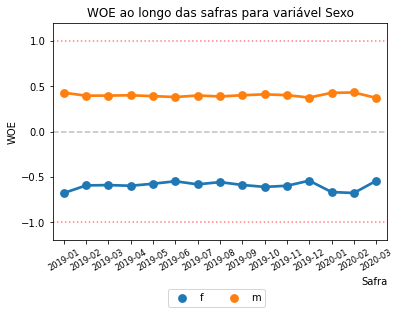

In [54]:
fig, ax = plt.subplots()
variavel='sexo'

# Comando principal do gráfico
sns.pointplot(data=tab.reset_index(), y = 'WOE', x = 'data_ref', hue=variavel, ax=ax);

# Rotacionar os rótulos do eixo X
labs = tab.index.get_level_values(level=0).unique()
labs2 = [x.to_period('M') for x in labs]

ax.set_xticklabels(labs2,rotation=30, fontsize='small')
ax.legend(bbox_to_anchor=(.65, -.2), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(1.2, max(tab.WOE))
ymin = min(-1.2, min(tab.WOE))
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo das safras para variável {variavel.capitalize()}')
ax.set_xlabel('Safra', loc='right');

Como podemos observar, o WOE, que está associado aos parâmetros da regressão logística, não é afetado por períodos de alta sistêmica.

Neste caso, vemos que o WOE permanece bastante estável no tempo, indicando uma variável bem robusta e confiável.

### Calculando o IV no tempo

Uma faceta importante de muitos projetos reais de ciência de dados está em efeitos temporais que podem ocasionar comportamentos preditivos muito bons, mas inconsistentes no tempo.

Por isso é muito importante realizar análises no tempo, para ter mais segurança de que uma variável com alto poder preditivo continue assim quando o modelo for aplicado.

In [55]:
tab.head()

doador           sim   nao     N  tx_evento  pct_evento  pct_nao_evento  \
data_ref   sexo                                                           
2019-01-01 f     219  4781  5000     0.0438    0.264493        0.521260   
           m     609  4391  5000     0.1218    0.735507        0.478740   
2019-02-01 f     254  4746  5000     0.0508    0.287330        0.520623   
           m     630  4370  5000     0.1260    0.712670        0.479377   
2019-03-01 f     280  4720  5000     0.0560    0.289555        0.522529   

doador                WOE  
data_ref   sexo            
2019-01-01 f    -0.678436  
           m     0.429403  
2019-02-01 f    -0.594394  
           m     0.396531  
2019-03-01 f    -0.590333

In [57]:
((tab.pct_evento - tab.pct_nao_evento)*tab.WOE)

data_ref    sexo
2019-01-01  f       0.174200
            m       0.110257
2019-02-01  f       0.138668
            m       0.092508
2019-03-01  f       0.137532
            m       0.092580
2019-04-01  f       0.140670
            m       0.094283
2019-05-01  f       0.131623
            m       0.089522
2019-06-01  f       0.121268
            m       0.084340
2019-07-01  f       0.135053
            m       0.092420
2019-08-01  f       0.125332
            m       0.087156
2019-09-01  f       0.137877
            m       0.093832
2019-10-01  f       0.146990
            m       0.099022
2019-11-01  f       0.141004
            m       0.094807
2019-12-01  f       0.118189
            m       0.082002
2020-01-01  f       0.169986
            m       0.108953
2020-02-01  f       0.174449
            m       0.111123
2020-03-01  f       0.117959
            m       0.080779
dtype: float64

<AxesSubplot:xlabel='data_ref'>

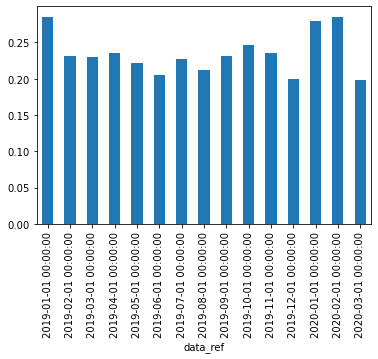

In [62]:
iv_sexo = ((tab.pct_evento - tab.pct_nao_evento)*tab.WOE).groupby(level=0).sum();
iv_sexo.plot.bar()

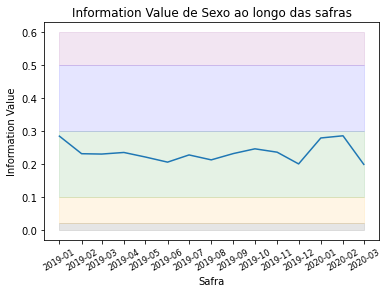

In [58]:
def plot_iv(IV):
    fig, ax = plt.subplots()
    x = IV.index
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Sexo ao longo das safras")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Safra")
    
plot_iv(iv_sexo)

## Referências

|||
|:-|:-|
|<div><img src="attachment:image.png" width="150"/></div>| **Intelligent Credit Scoring**: Building and Implementing Better Credit Risk Scorecards, por Naeem Siddiqi Capa dura, 10 janeiro 2017, editora Wiley |
